### Analysis and plots for reproducibility data


In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import matplotlib.colors as clr
import matplotlib as mpl
import statannot
from statannot import add_stat_annotation
import statannotations
from statannotations.Annotator import Annotator
import scipy.stats as stats
import pingouin as pg


#function that defines colors
def rgb(red, green, blue, maxColorValue):
    return (red/maxColorValue, green/maxColorValue, blue/maxColorValue)

#colors for barplots
col_1 = rgb(red=254, green=154, blue=1, maxColorValue=255) #yellow
col_2 = rgb(red=0, green=128, blue=128, maxColorValue=255) #green
col_3 = rgb(red=128, green=0, blue=128, maxColorValue=255) #purple
col_4 = rgb(red=138, green=54, blue=15, maxColorValue=255) #brown

#colors for heatmap
col_6 = rgb(red=254, green=254, blue=98, maxColorValue=255) #pale yellow
col_7 = rgb(red=211, green=95, blue=183, maxColorValue=255) #pink

#changing default font for matplotlib
mpl.rcParams['font.family'] = 'Roboto'

#output directory to save figures
odir= '/nfs/rnas/PRECISION/figures'

/config/.conda/envs/REPRO/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/config/.conda/envs/REPRO/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [32]:
# Statistical test to compare median LCC of features against R extracted with B=12HU and B=25HU
df_name='reproRBfixed'
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]

data_df_B12=df.loc[df["setting"]=="RB12"]
data_df_B25=df.loc[df["setting"]=="RB25"]


# Liver and lung
data_df_B12_liver=data_df_B12[data_df_B12['lesion_location']=='liver']
data_df_B25_liver=data_df_B25[data_df_B25['lesion_location']=='liver']
data_df_B12_lung=data_df_B12[data_df_B12['lesion_location']=='lung']
data_df_B25_lung=data_df_B25[data_df_B25['lesion_location']=='lung']

data_df_B12_liver=data_df_B12_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_liver=data_df_B25_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B12_lung=data_df_B12_lung.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_lung=data_df_B25_lung.groupby(['feature'])['ICC_LCL'].median()


data_df_B12_liver.reset_index(drop=True, inplace=True)
data_df_B25_liver.reset_index(drop=True, inplace=True)

data_df_B12_lung.reset_index(drop=True, inplace=True)
data_df_B25_lung.reset_index(drop=True, inplace=True)

# Perform Wilcoxon signed-rank test
print("WILCOXON")
stat_liver, p_liver = stats.wilcoxon(data_df_B12_liver, data_df_B25_liver)
stat_lung, p_lung = stats.wilcoxon(data_df_B12_lung, data_df_B25_lung)

alpha = 0.05
if p_liver > alpha:
    print('NOT SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))
else:
    print('SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))

if p_lung > alpha:
    print('NOT SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))
else:
    print('SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))

# MEDIANS
B12_liver=data_df_B12_liver
B25_liver=data_df_B25_liver
B12_lung=data_df_B12_lung
B25_lung=data_df_B25_lung
print("MEDIANS!!")
print('Median (IQR) liver B12:', np.percentile(B12_liver,50), '(', np.percentile(B12_liver,25), '-',np.percentile(B12_liver,75), ')')
print('Median (IQR) liver B25:', np.percentile(B25_liver,50), '(', np.percentile(B25_liver,25), '-',np.percentile(B25_liver,75), ')')
print('Median (IQR) lung B12:', np.percentile(B12_lung,50), '(', np.percentile(B12_lung,25), '-',np.percentile(B12_lung,75), ')')
print('Median (IQR) lung B25:', np.percentile(B25_lung,50), '(', np.percentile(B25_lung,25), '-',np.percentile(B25_lung,75), ')')

# Effect size
differences_liver = B12_liver- B25_liver
differences_lung = B12_lung - B25_lung

effect_size_liver = abs(np.mean(differences_liver) / np.std(differences_liver, ddof=1))
effect_size_lung = abs(np.mean(differences_lung) / np.std(differences_lung, ddof=1))

print("EFFECT SIZE")
print('Effect size for liver:', effect_size_liver)
print('Effect size for lung:', effect_size_lung)

# Compute Cohen's delta
cohen_d_liver = pg.compute_effsize(B12_liver, B25_liver, paired=True, eftype='cohen')
cohen_d_lung = pg.compute_effsize(B12_lung, B25_lung, paired=True, eftype='cohen')

print('Cohen\'s delta for liver:', cohen_d_liver)
print('Cohen\'s delta for lung:', cohen_d_lung)

/config/.conda/envs/REPRO/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


WILCOXON
SIGNIFICANT FOR LIVER!
Wilcoxon signed-rank test results: z = 690.000, p = 0.000103898
NOT SIGNIFICANT FOR LUNG!
Wilcoxon signed-rank test results: z = 1122.500, p = 0.482511153
MEDIANS!!
Median (IQR) liver B12: 0.422 ( 0.346 - 0.513 )
Median (IQR) liver B25: 0.407 ( 0.291 - 0.5355000000000001 )
Median (IQR) lung B12: 0.573 ( 0.4025 - 0.7012499999999999 )
Median (IQR) lung B25: 0.5725 ( 0.44275 - 0.6964999999999999 )
EFFECT SIZE
Effect size for liver: 0.3790292775324069
Effect size for lung: 0.004259471216499949
Cohen's delta for liver: 0.1245568051917759
Cohen's delta for lung: -0.0014715896230504683


In [33]:
# Statistical test to compare median LCC of features against B extracted with R=1mm and R=3mm
df_name='reproBRfixed'
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]

data_df_B12=df.loc[df["setting"]=="BR1"]
data_df_B25=df.loc[df["setting"]=="BR3"]


# Liver and lung
data_df_B12_liver=data_df_B12[data_df_B12['lesion_location']=='liver']
data_df_B25_liver=data_df_B25[data_df_B25['lesion_location']=='liver']
data_df_B12_lung=data_df_B12[data_df_B12['lesion_location']=='lung']
data_df_B25_lung=data_df_B25[data_df_B25['lesion_location']=='lung']

data_df_B12_liver=data_df_B12_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_liver=data_df_B25_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B12_lung=data_df_B12_lung.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_lung=data_df_B25_lung.groupby(['feature'])['ICC_LCL'].median()


data_df_B12_liver.reset_index(drop=True, inplace=True)
data_df_B25_liver.reset_index(drop=True, inplace=True)

data_df_B12_lung.reset_index(drop=True, inplace=True)
data_df_B25_lung.reset_index(drop=True, inplace=True)

# Perform Wilcoxon signed-rank test
print("WILCOXON")
stat_liver, p_liver = stats.wilcoxon(data_df_B12_liver, data_df_B25_liver)
stat_lung, p_lung = stats.wilcoxon(data_df_B12_lung, data_df_B25_lung)

alpha = 0.05
if p_liver > alpha:
    print('NOT SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))
else:
    print('SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))

if p_lung > alpha:
    print('NOT SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))
else:
    print('SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))

# MEDIANS
BR1_liver=data_df_B12_liver
BR3_liver=data_df_B25_liver
BR1_lung=data_df_B12_lung
BR3_lung=data_df_B25_lung
print("MEDIANS!!")
print('Median (IQR) liver R1:', np.percentile(BR1_liver,50), '(', np.percentile(BR1_liver,25), '-',np.percentile(BR1_liver,75), ')')
print('Median (IQR) liver R3:', np.percentile(BR3_liver,50), '(', np.percentile(BR3_liver,25), '-',np.percentile(BR3_liver,75), ')')
print('Median (IQR) lung R1:', np.percentile(BR1_lung,50), '(', np.percentile(BR1_lung,25), '-',np.percentile(BR1_lung,75), ')')
print('Median (IQR) lung R3:', np.percentile(BR3_lung,50), '(', np.percentile(BR3_lung,25), '-',np.percentile(BR3_lung,75), ')')


# Effect size
differences_liver = BR1_liver- BR3_liver
differences_lung = BR1_lung - BR3_lung

effect_size_liver = abs(np.mean(differences_liver) / np.std(differences_liver, ddof=1))
effect_size_lung = abs(np.mean(differences_lung) / np.std(differences_lung, ddof=1))

print("EFFECT SIZE")
print('Effect size for liver:', effect_size_liver)
print('Effect size for lung:', effect_size_lung)

# Compute Cohen's delta
cohen_d_liver = pg.compute_effsize(BR1_liver, BR3_liver, paired=True, eftype='cohen')
cohen_d_lung = pg.compute_effsize(BR1_lung, BR3_lung, paired=True, eftype='cohen')

print('Cohen\'s delta for liver:', cohen_d_liver)
print('Cohen\'s delta for lung:', cohen_d_lung)

WILCOXON
SIGNIFICANT FOR LIVER!
Wilcoxon signed-rank test results: z = 89.500, p = 0.000000000
SIGNIFICANT FOR LUNG!
Wilcoxon signed-rank test results: z = 171.000, p = 0.000000000
MEDIANS!!
Median (IQR) liver R1: 0.805 ( 0.672 - 0.9185000000000001 )
Median (IQR) liver R3: 0.921 ( 0.8205 - 0.9815 )
Median (IQR) lung R1: 0.9295 ( 0.8234999999999999 - 0.997 )
Median (IQR) lung R3: 0.967 ( 0.93 - 0.999 )
EFFECT SIZE
Effect size for liver: 0.732315699066419
Effect size for lung: 0.579103806546462
Cohen's delta for liver: -0.4806996855355939
Cohen's delta for lung: -0.5040834413511841


In [34]:
### statistical test for reproducibility against R withotu seprating lung adn liver

## reprodcuibiltiya gainst R, so comparing B12 and B25
# Statistical test to compare median LCC of features against R extracted with B=12HU and B=25HU
df_name='reproRBfixed'
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]

data_df_B12=df.loc[df["setting"]=="RB12"]
data_df_B25=df.loc[df["setting"]=="RB25"]


# Liver and lung
data_df_B12=data_df_B12.groupby(['feature'])['ICC_LCL'].median()
data_df_B25=data_df_B25.groupby(['feature'])['ICC_LCL'].median()
data_df_B12.reset_index(drop=True, inplace=True)
data_df_B25.reset_index(drop=True, inplace=True)

# Perform Wilcoxon signed-rank test
print("WILCOXON")
stat_liver, p_liver = stats.wilcoxon(data_df_B12, data_df_B25)

alpha = 0.05
if p_liver > alpha:
    print('NOT SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))
else:
    print('SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))

# MEDIANS
B12_liver=data_df_B12
B25_liver=data_df_B25

print("MEDIANS!!")
print('Median (IQR) liver B12:', np.percentile(B12_liver,50), '(', np.percentile(B12_liver,25), '-',np.percentile(B12_liver,75), ')')
print('Median (IQR) liver B25:', np.percentile(B25_liver,50), '(', np.percentile(B25_liver,25), '-',np.percentile(B25_liver,75), ')')


# Effect size
differences_liver = B12_liver- B25_liver

effect_size_liver = abs(np.mean(differences_liver) / np.std(differences_liver, ddof=1))

print("EFFECT SIZE")
print('Effect size for liver:', effect_size_liver)

# Compute Cohen's delta
cohen_d_liver = pg.compute_effsize(B12_liver, B25_liver, paired=True, eftype='cohen')

print('Cohen\'s delta for liver:', cohen_d_liver)


/config/.conda/envs/REPRO/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


WILCOXON
SIGNIFICANT FOR LIVER!
Wilcoxon signed-rank test results: z = 777.500, p = 0.000627871
MEDIANS!!
Median (IQR) liver B12: 0.437 ( 0.355 - 0.5245 )
Median (IQR) liver B25: 0.44 ( 0.33 - 0.526 )
EFFECT SIZE
Effect size for liver: 0.3452432538489155
Cohen's delta for liver: 0.10834493893533097


In [5]:
# Statistical test to compare lung adn liver lesions in reproducibilty against R 
df_name='reproRBfixed'
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]

data_df_B12=df.loc[df["setting"]=="RB12"]
data_df_B25=df.loc[df["setting"]=="RB25"]


# Liver and lung
data_df_B12_liver=data_df_B12[data_df_B12['lesion_location']=='liver']
data_df_B25_liver=data_df_B25[data_df_B25['lesion_location']=='liver']
data_df_B12_lung=data_df_B12[data_df_B12['lesion_location']=='lung']
data_df_B25_lung=data_df_B25[data_df_B25['lesion_location']=='lung']

data_df_B12_liver=data_df_B12_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_liver=data_df_B25_liver.groupby(['feature'])['ICC_LCL'].median()
data_df_B12_lung=data_df_B12_lung.groupby(['feature'])['ICC_LCL'].median()
data_df_B25_lung=data_df_B25_lung.groupby(['feature'])['ICC_LCL'].median()


data_df_B12_liver.reset_index(drop=True, inplace=True)
data_df_B25_liver.reset_index(drop=True, inplace=True)

data_df_B12_lung.reset_index(drop=True, inplace=True)
data_df_B25_lung.reset_index(drop=True, inplace=True)

# Perform Wilcoxon signed-rank test
print("WILCOXON")
stat_liver, p_liver = stats.wilcoxon(data_df_B12_liver, data_df_B12_lung)
stat_lung, p_lung = stats.wilcoxon(data_df_B25_liver, data_df_B25_lung)

alpha = 0.05
if p_liver > alpha:
    print('NOT SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))
else:
    print('SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))

if p_lung > alpha:
    print('NOT SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))
else:
    print('SIGNIFICANT FOR LUNG!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_lung, p_lung))

# MEDIANS
BR1_liver=data_df_B12_liver
BR3_liver=data_df_B25_liver
BR1_lung=data_df_B12_lung
BR3_lung=data_df_B25_lung
print("MEDIANS!!")
print('Median (IQR) liver R1:', np.percentile(BR1_liver,50), '(', np.percentile(BR1_liver,25), '-',np.percentile(BR1_liver,75), ')')
print('Median (IQR) liver R3:', np.percentile(BR3_liver,50), '(', np.percentile(BR3_liver,25), '-',np.percentile(BR3_liver,75), ')')
print('Median (IQR) lung R1:', np.percentile(BR1_lung,50), '(', np.percentile(BR1_lung,25), '-',np.percentile(BR1_lung,75), ')')
print('Median (IQR) lung R3:', np.percentile(BR3_lung,50), '(', np.percentile(BR3_lung,25), '-',np.percentile(BR3_lung,75), ')')


# Effect size
differences_liver = BR1_lung- BR1_liver
differences_lung = BR3_lung - BR3_liver

effect_size_liver = abs(np.mean(differences_liver) / np.std(differences_liver, ddof=1))
effect_size_lung = abs(np.mean(differences_lung) / np.std(differences_lung, ddof=1))

print("EFFECT SIZE")
print('Effect size for liver:', effect_size_liver)
print('Effect size for lung:', effect_size_lung)

# Compute Cohen's delta
cohen_d_liver = pg.compute_effsize(BR1_liver, BR1_lung, paired=True, eftype='cohen')
cohen_d_lung = pg.compute_effsize(BR3_liver, BR3_lung, paired=True, eftype='cohen')

print('Cohen\'s delta for liver:', cohen_d_liver)
print('Cohen\'s delta for lung:', cohen_d_lung)

/config/.conda/envs/REPRO/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


WILCOXON
SIGNIFICANT FOR LIVER!
Wilcoxon signed-rank test results: z = 856.000, p = 0.000000978
SIGNIFICANT FOR LUNG!
Wilcoxon signed-rank test results: z = 602.500, p = 0.000000004
MEDIANS!!
Median (IQR) liver R1: 0.422 ( 0.346 - 0.513 )
Median (IQR) liver R3: 0.407 ( 0.291 - 0.5355000000000001 )
Median (IQR) lung R1: 0.573 ( 0.4025 - 0.7012499999999999 )
Median (IQR) lung R3: 0.5725 ( 0.44275 - 0.6964999999999999 )
EFFECT SIZE
Effect size for liver: 0.5988684039979385
Effect size for lung: 0.7681404967845166
Cohen's delta for liver: -0.5230963476014407
Cohen's delta for lung: -0.6027424934709357


In [35]:
### statistical test for reproducibility against B withotu seprating lung adn liver
df_name='reproBRfixed'
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]

data_df_B12=df.loc[df["setting"]=="BR1"]
data_df_B25=df.loc[df["setting"]=="BR3"]


# Liver and lung
data_df_B12=data_df_B12.groupby(['feature'])['ICC_LCL'].median()
data_df_B25=data_df_B25.groupby(['feature'])['ICC_LCL'].median()
data_df_B12.reset_index(drop=True, inplace=True)
data_df_B25.reset_index(drop=True, inplace=True)

# Perform Wilcoxon signed-rank test
print("WILCOXON")
stat_liver, p_liver = stats.wilcoxon(data_df_B12, data_df_B25)

alpha = 0.05
if p_liver > alpha:
    print('NOT SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))
else:
    print('SIGNIFICANT FOR LIVER!')
    print('Wilcoxon signed-rank test results: z = {:.3f}, p = {:.9f}'.format(stat_liver, p_liver))

# MEDIANS
B12_liver=data_df_B12
B25_liver=data_df_B25

print("MEDIANS!!")
print('Median (IQR) liver R1:', np.percentile(B12_liver,50), '(', np.percentile(B12_liver,25), '-',np.percentile(B12_liver,75), ')')
print('Median (IQR) liver R3:', np.percentile(B25_liver,50), '(', np.percentile(B25_liver,25), '-',np.percentile(B25_liver,75), ')')


# Effect size
differences_liver = B12_liver- B25_liver

effect_size_liver = abs(np.mean(differences_liver) / np.std(differences_liver, ddof=1))

print("EFFECT SIZE")
print('Effect size for liver:', effect_size_liver)

# Compute Cohen's delta
cohen_d_liver = pg.compute_effsize(B12_liver, B25_liver, paired=True, eftype='cohen')

print('Cohen\'s delta for liver:', cohen_d_liver)


WILCOXON
SIGNIFICANT FOR LIVER!
Wilcoxon signed-rank test results: z = 72.500, p = 0.000000000
MEDIANS!!
Median (IQR) liver R1: 0.833 ( 0.706 - 0.9455 )
Median (IQR) liver R3: 0.929 ( 0.853 - 0.9884999999999999 )
EFFECT SIZE
Effect size for liver: 0.700491598042857
Cohen's delta for liver: -0.4741612475477365


### Reproducibility (R) for both experiments

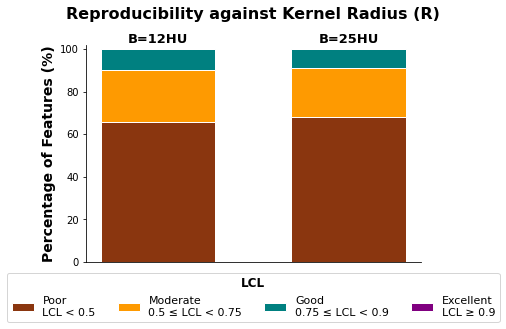

In [11]:
from matplotlib.lines import Line2D
from matplotlib.text import Text

df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/reproRBfixed.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
settings=['RB12', 'RB25']
groups=['poor', 'moderate', 'good', 'excellent']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()
for s in settings:
    df_s=[]
    df_cols=['setting', 'poor', 'moderate', 'good', 'excellent']

    if s=='all':
        new_df=df
    else:
        new_df=df[df['setting']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'setting':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot = pd.concat([df_tot, df_s], axis=0) 

# plot
barWidth = 0.3
r = [0,0.5]
names = ('B=12HU', 'B=25HU')
# Create green Bars
plt.bar(r, df_tot["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor\nLCL < 0.5")
# Create orange Bars
plt.bar(r, df_tot["moderate"], bottom=df_tot["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate\n0.5 ≤ LCL < 0.75")
# Create blue Bars
plt.bar(r,df_tot["good"], bottom=[i+j for i,j in zip(df_tot["poor"], df_tot["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good\n0.75 ≤ LCL < 0.9")
 # Create blue Bars
plt.bar(r,df_tot["excellent"], bottom=[i+j+k for i,j,k in zip(df_tot["poor"], df_tot["moderate"], df_tot["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent\nLCL ≥ 0.9")


plt.xticks([], [])
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
legend = plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize=11, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')
plt.ylim(0,102)
plt.title('Reproducibility against Kernel Radius (R)', fontsize=16, weight='bold', y=1.09)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add subtitles
for i in range(len(r)):
    plt.text(x=r[i], y=103, s=names[i], ha='center', fontsize=13, weight='bold')

# Save figure
plt.savefig(odir+'/Figure3A_reproR_legend.svg',bbox_inches='tight', dpi=300)

### Reproducibility per feat class

In [ ]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
sett='BR3'
df_name='reproBRfixed'

df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett]
groups=['poor', 'moderate', 'good', 'excellent']
feat_classes=['firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm']
df=df.loc[df["lesion_location"]=='liver'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_liver=pd.DataFrame()
for s in feat_classes:
    df_s=[]
    if s=='all':
        new_df=df
    else:
        new_df=df[df['feature_class']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe
    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'feature_class':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot_liver = pd.concat([df_tot_liver, df_s], axis=0) 


############################################## LUNG
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett]
groups=['poor', 'moderate', 'good', 'excellent']
feat_classes=['firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm']
df=df.loc[df["lesion_location"]=='lung'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_lung=pd.DataFrame()
for s in feat_classes:
    df_s=[]

    if s=='all':
        new_df=df
    else:
        new_df=df[df['feature_class']==s]
  
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df.groupby(['feature'])[metric].median() #We compute the median of every feature for all lesions, all cohorts
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe
    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'feature_class':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})

    df_s=pd.DataFrame(df_s)
    df_tot_lung= pd.concat([df_tot_lung, df_s], axis=0) 

df_tot_lung=df_tot_lung.set_index('feature_class')
df_tot_liver=df_tot_liver.set_index('feature_class')
df1=df_tot_liver
df2=df_tot_lung

# plot
barWidth = 0.4
names2 = ('FO', 'GLCM', 'GLDM', 'GRLM', 'GSZM', 'NGTM')
X_axis = np.arange(len(names2))

# Create green Bars
plt.bar(X_axis + 0.2, df1["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")
plt.bar(X_axis - 0.2, df2["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")

# Create orange Bars
plt.bar(X_axis + 0.2, df1["moderate"], bottom=df1["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")
plt.bar(X_axis - 0.2, df2["moderate"], bottom=df2["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")

# Create blue Bars
plt.bar(X_axis + 0.2,df1["good"], bottom=[i+j for i,j in zip(df1["poor"], df1["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")
plt.bar(X_axis - 0.2,df2["good"], bottom=[i+j for i,j in zip(df2["poor"], df2["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")

 # Create blue Bars
plt.bar(X_axis + 0.2,df1["excellent"], bottom=[i+j+k for i,j,k in zip(df1["poor"], df1["moderate"], df1["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")
plt.bar(X_axis - 0.2,df2["excellent"], bottom=[i+j+k for i,j,k in zip(df2["poor"], df2["moderate"], df2["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")

# Custom x axis
r=[-0.2, 0.2,  0.8, 1.2, 1.8, 2.2,  2.8, 3.2, 3.8, 4.2, 4.8, 5.2]
names = ('Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver')
plt.xticks(r, names, rotation=35)
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
plt.ylim(0,102)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Reproducibility against B \n per feature class (fixed R=3mm)',  weight='bold', y=1.1, fontsize=16)

# Add subtitles
r2=[0,1,2,3,4,5]
for i in range(len(names2)):
    plt.text(x=r2[i], y=103, s=names2[i], ha='center', fontsize=13, weight='bold')

# Adding Legend with bold title + not duplicated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, fontsize=12, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')

plt.savefig(odir+'/Figure3D_reproBperfeatclass_R3.jpg',bbox_inches='tight', dpi=300)

### Reproducibility per cohort


In [ ]:
# Import dataframe containing repeatability data for all settings, all cohorts and all lesion locations
sett='BR3'
df_name='reproBRfixed'

df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett]
groups=['poor', 'moderate', 'good', 'excellent']
primary_tumors=['colorectal', 'lung', 'mixed', 'neuroendocrine', 'all']
df=df.loc[df["lesion_location"]=='liver'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)


#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_liver=pd.DataFrame()
for s in primary_tumors:
    df_s=[]
    if s=='all':
        new_df2=df
    else:
        new_df2=df[df['final_primary_tumor']==s]
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df2.groupby(['feature'])[metric].median() #We compute the median for every feature
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'primary_tumor':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})
    df_s=pd.DataFrame(df_s)
    df_tot_liver = pd.concat([df_tot_liver, df_s], axis=0) 


#### LUNG DATAFRAME
df=pd.read_csv('/nfs/rnas/PRECISION/pretty_codes/'+df_name+'.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"]
df=df.loc[df["setting"]==sett]
groups=['poor', 'moderate', 'good', 'excellent']
primary_tumors=['colorectal', 'lung', 'mixed', 'neuroendocrine', 'all']
df=df.loc[df["lesion_location"]=='lung'] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot_lung=pd.DataFrame()
for s in primary_tumors:
    df_s=[]
    if s=='all':
        new_df2=df
    else:
        new_df2=df[df['final_primary_tumor']==s]
    metric='ICC_LCL' #We use the lower bound of the 95%CI
    medians = new_df2.groupby(['feature'])[metric].median() #We compute the median for every feature
    medians= medians.sort_values(ascending=False)
    df_medians=medians.to_frame() #series to dataframe

    # Now we create a column "poor, moderate, good, excellent" according to the ICC_LCL median:
    values=['excellent','good', 'moderate', 'poor']
    conditions=[(df_medians['ICC_LCL']>=0.9),(df_medians['ICC_LCL']>=0.75)&(df_medians['ICC_LCL']<0.9),(df_medians['ICC_LCL']>=0.5)&(df_medians['ICC_LCL']<0.75),(df_medians['ICC_LCL']<0.5)]
    df_medians['group']=np.select(conditions, values)

    # We count the percentage of each group 
    counts = df_medians['group'].value_counts().to_dict()
    total = sum(counts.values(), 0) #total number of features
    pctg_counts = {k: v / total for k, v in counts.items()}
    res = dict() #resulting dictionary
    for key in pctg_counts:
        res[key] = round((pctg_counts[key])*100,12)

    # Loop through group to obtain the setting df
    if "poor" in res: 
        val_poor=res["poor"]
    else:
        val_poor=0.0

    if "moderate" in res: 
        val_mod=res["moderate"]
    else:
        val_mod=0.0

    if "good" in res: 
        val_good=res["good"]
    else:
        val_good=0.0

    if "excellent" in res: 
        val_exc=res["excellent"]
    else:
        val_exc=0.0

    df_s.append({
        'primary_tumor':s,
        'poor':val_poor,
        'moderate':val_mod,
        'good':val_good,
        'excellent':val_exc})
    df_s=pd.DataFrame(df_s)
    df_tot_lung = pd.concat([df_tot_lung, df_s], axis=0) 

df_tot_lung=df_tot_lung.set_index('primary_tumor')
df_tot_liver=df_tot_liver.set_index('primary_tumor')

df1=df_tot_liver
df2=df_tot_lung

# plot
barWidth = 0.4
names2 = ('CRC', 'LUNG', 'MIXED', 'NEURO', 'ALL')
X_axis = np.arange(len(names2))

# Create green Bars
plt.bar(X_axis + 0.2, df1["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")
plt.bar(X_axis - 0.2, df2["poor"], color=col_4, edgecolor='white', width=barWidth, label="Poor")

# Create orange Bars
plt.bar(X_axis + 0.2, df1["moderate"], bottom=df1["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")
plt.bar(X_axis - 0.2, df2["moderate"], bottom=df2["poor"], color=col_1, edgecolor='white', width=barWidth, label="Moderate")

# Create blue Bars
plt.bar(X_axis + 0.2,df1["good"], bottom=[i+j for i,j in zip(df1["poor"], df1["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")
plt.bar(X_axis - 0.2,df2["good"], bottom=[i+j for i,j in zip(df2["poor"], df2["moderate"])], color=col_2, edgecolor='white', width=barWidth, label="Good")

 # Create blue Bars
plt.bar(X_axis + 0.2,df1["excellent"], bottom=[i+j+k for i,j,k in zip(df1["poor"], df1["moderate"], df1["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")
plt.bar(X_axis - 0.2,df2["excellent"], bottom=[i+j+k for i,j,k in zip(df2["poor"], df2["moderate"], df2["good"])], color=col_3, edgecolor='white', width=barWidth, label="Excellent")

# Custom x axis
r=[-0.2, 0.2,  0.8, 1.2, 1.8, 2.2,  2.8, 3.2, 3.8, 4.2]
names = ('Lung', 'Liver', 'Lung', 'Liver', 'Lung', 'Liver', ' ', 'Liver', 'Lung', 'Liver')
plt.xticks(r, names, rotation=35, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Percentage of Features (%)", fontsize=14, weight='bold')
plt.ylim(0,102)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, title="LCL", fontsize=12, title_fontsize='large')
plt.title('Reproducibility against B \n per cohort (fixed R=3mm)',  weight='bold', y=1.1, fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add subtitles
r2=[0,1,2,3,4]
for i in range(len(names2)):
    plt.text(x=r2[i], y=103, s=names2[i], ha='center', fontsize=13, weight='bold')

# Adding Legend with bold title + not duplicated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=12, title="LCL", title_fontsize='large')
legend.get_title().set_fontweight('bold')
plt.savefig(odir+'/FigureE5_repropercohort_'+sett+'.jpg',bbox_inches='tight', dpi=300)

### Heatmap precision 

In [ ]:
experiment='liver'

#We create a df where rows are feaures and each column is one cohort
df=pd.read_csv('/nfs/rnas/PRECISION/df_repeat.csv') #read repeatability csv
df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
df = df.loc[df["feature"] != "firstorder_TotalEnergy"] #remove total energy because its the same as energy
df=df.loc[df["setting"]=="R3B12"] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df=df.loc[df["lesion_location"]==experiment] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
groups=['poor', 'moderate', 'good', 'excellent']

#Going to create one dataframe per setting (whcih will be x axis of my plot). It will have 5 columns: setting, poor, moderate, good, excellent and 1 row.
df_tot=pd.DataFrame()
LICC_metric='ICC_LCL' #We use the lower bound of the 95%CI
LICC_medians = df.groupby(['feature'])[LICC_metric].median() #We compute the median for every feature
df_LICC_medians=LICC_medians.to_frame().reset_index()  #series to dataframe

#concatenate all three dataframes:
df_total=df_LICC_medians.round(2)
df_final_total= df_total[['feature','ICC_LCL']]
df_final_total["cohort_lesion"]='repeat_R3B12'
df_tot = pd.concat([df_tot, df_final_total], axis=0) 

# we add repro experiments columns
repro_experiments=['reproRB12', 'reproBR3']
df_tot2=pd.DataFrame()
for mydf in repro_experiments:
    #We create a df where rows are feaures and each column is one cohort
    df=pd.read_csv('/nfs/rnas/PRECISION/paper/df_'+mydf+'.csv') #read repeatability csv
    df['primary_tumor'] = df['primary_tumor'].replace(['cholangiocarcinoma'], 'biliary_tract') #correct name missmatch
    df=df.loc[df["lesion_location"]!='other'] #ensure only liver and lung lesions present
    df = df.loc[df["feature"] != "firstorder_TotalEnergy"] #remove total energy because its the same as energy
    df=df.loc[df["lesion_location"]==experiment] #SETTING FILTER. I chose R3B12 because it is the setting with the highest number of repeatable features. 
    df= df.fillna(1.0) #replacing NaNs for ICC_LCL that have NaN (because it's 1, only happened then)
    groups=['poor', 'moderate', 'good', 'excellent']

    LICC_metric='ICC_LCL' #We use the lower bound of the 95%CI
    LICC_medians = df.groupby(['feature'])[LICC_metric].median() #We compute the median for every feature
    df_LICC_medians=LICC_medians.to_frame().reset_index()  #series to dataframe

    #concatenate all three dataframes:
    df_total=df_LICC_medians.round(2)
    df_final_total= df_total[['feature','ICC_LCL']]
    df_final_total["cohort_lesion"] =mydf
    df_tot2 = pd.concat([df_tot2, df_final_total], axis=0) 

#we join repeat and repro 
final_df_tot=pd.concat([df_tot, df_tot2], axis=0) 

#from df_tot we create df_plot
names=('repeat_R3B12', 'reproRB12', 'reproBR3')

df_plot=pd.DataFrame()
for name in names:
    df = final_df_tot[final_df_tot['cohort_lesion'] == name]
    df = df.rename(columns={"ICC_LCL":name})
    df = df[['feature',name]]
    df = df.set_index('feature')
    df_plot = pd.concat([df_plot, df], axis=1) 


#We plot the heatmap
plt.figure(figsize=(9,27))
color=sns.diverging_palette(0, 259, s=90,n=256)
# sns.set(font_scale=1.2) 
ax= sns.heatmap(df_plot, cmap=color, vmin=0, vmax=1, cbar_kws={"shrink": 0.5, "location": "right"})
# ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title('Liver lesions', weight='bold', y=1.05, fontsize=17)
plt.xticks([], [])
plt.ylabel("Features", fontsize=15, weight='bold')

# Add subtitles
r2=[0.5,1.5,2.5]
names2=('Repeatability', 'Reproducibility \n against R', 'Reproducibility \n against B')
for i in range(len(names2)):
    plt.text(x=r2[i], y=-1, s=names2[i], ha='center', fontsize=14, weight='bold')
plt.savefig(odir+'/Figure4precise_'+experiment+'.svg',bbox_inches='tight', dpi=300)